Tutorial: https://www.analyticsvidhya.com/blog/2021/05/sms-spam-detection-using-lstm-a-hands-on-guide/

In [167]:
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('dark_background')
import warnings
warnings.simplefilter(action='ignore', category=Warning)
from keras.layers import Dense, Embedding, LSTM, Dropout
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np
import tensorflow as tf

Unpreprocessed file: merged_cleaned.csv
(not executable on Colab beacause of to little RAM, not executable on own machine since it takes for ever...)

In [168]:
image_folder = 'Images/lstm_SMS_preprocessed/LSTM_SMS_'
data_path = '../../Data/preprocessed/spam_preprocessed.csv'

enron_prep.csv:

In [100]:
image_folder = 'Images/lstm_enron_preprocessed/LSTM_ENRON_'
data_path = '../../Data/preprocessed/enron_preprocessed.csv'

#MAIN:

In [169]:
print("reading file: ", data_path)
df = pd.read_csv(data_path, encoding = "latin-1")
df.head()

reading file:  ../../Data/preprocessed/spam_preprocessed.csv


,label,text
0,0,go jurong point avail bugi n great world la e ...
1,0,ok lar joke wif u oni
2,1,free entri wkli comp win fa cup final tkt may ...
3,0,u dun say earli hor u c alreadi say
4,0,nah think goe usf live around though


In [170]:
df.shape

(5157, 2)

#Drop Null values:
Somehow it did not work to drop NULL values in preprocessing... Out of any reason there are some null falues in the data after reading the CSV even though they have not been there before writing the CSV file in the preprocessing skript!

In [171]:
df.isnull().sum()

label     0
text     15
dtype: int64

In [172]:
df.dropna(inplace=True)
df.isnull().sum()

label    0
text     0
dtype: int64

#Balancing Dataset: 

In [173]:
df_spam = df[df['label'] == 1]
df_ham  = df[df['label'] == 0]
print("Ham Dataset Shape:", df_ham.shape)
print("Spam Dataset Shape:", df_spam.shape)


Ham Dataset Shape: (4502, 2)
Spam Dataset Shape: (640, 2)


In [174]:
df_ham_downsampled = df_ham.sample(df_spam.shape[0])
df_ham_downsampled.shape

(640, 2)

In [175]:
df = pd.concat([df_spam, df_ham_downsampled])

<AxesSubplot:xlabel='label', ylabel='count'>

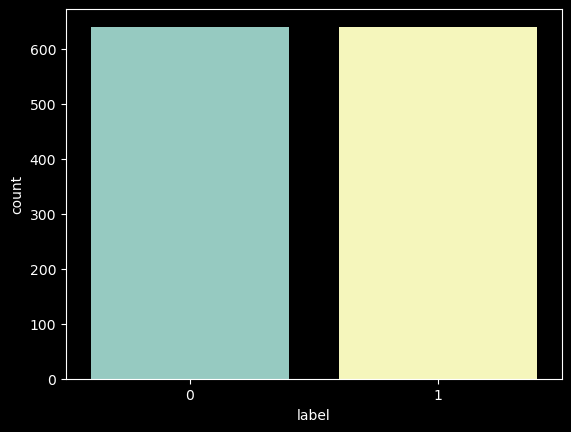

In [176]:
import seaborn as sns
sns.countplot(x=df["label"])

#Convert tokens into a numerical sequence:

In [177]:
X=df["text"]
#X=df["transformed_text"]
tokenizer = Tokenizer() #initializing the tokenizer
tokenizer.fit_on_texts(X)# fitting on the sms data
text_to_sequence = tokenizer.texts_to_sequences(X) # creating the numerical sequence

In [178]:
#tokenizer.index_word

In [179]:
len(tokenizer.index_word)

2731

We do have 130427 unique words!

In [180]:
#for i in range(3):
#        print("Text               : ",X[i] )
#        print("Numerical Sequence : ", text_to_sequence[i])

#Depending on the data this could fail since the index 0..2 could have been dropped in balancing the data! 

#Normalization:
Since all the messages are of different lengths also the sequences are of different length, so we have to padding the sequences with 0 to get equal length. Otherwise the sequences would not be compatible for the model!

In [183]:
max_length_sequence = max([len(i) for i in text_to_sequence]) # finding the length of largest sequence
padded_sequence = pad_sequences(text_to_sequence, maxlen=max_length_sequence, padding = "pre")
padded_sequence

array([[   0,    0,    0, ...,   81,   28,   94],
       [   0,    0,    0, ...,  858,   14,  859],
       [   0,    0,    0, ...,   82,  124,  222],
       ...,
       [   0,    0,    0, ...,  301,  244,  285],
       [   0,    0,    0, ...,   16,  370, 1094],
       [   0,    0,    0, ..., 2731,   49,  348]], dtype=int32)

The longest Sentence exists of 501

In [184]:
print("shape",len(padded_sequence), "rows x ",len(padded_sequence[0]),"cols")

shape 1280 rows x  45 cols


#Create LSTM Model:

In [185]:
TOT_SIZE = len(tokenizer.word_index)+1


def create_model():
      lstm_model = Sequential()
      lstm_model.add(Embedding(TOT_SIZE, 32, input_length=max_length_sequence))
      lstm_model.add(LSTM(100))
      lstm_model.add(Dropout(0.4))
      lstm_model.add(Dense(20, activation="relu"))

      lstm_model.add(Dropout(0.3))
      lstm_model.add(Dense(1, activation = "sigmoid"))
      return lstm_model

Metrics = [tf.keras.metrics.BinaryAccuracy(name='accuracy'),
           tf.keras.metrics.Precision(name='precision'),
           tf.keras.metrics.Recall(name='recall')
           ]

lstm_model = create_model()
lstm_model.compile(loss = "binary_crossentropy", optimizer = "adam", metrics=Metrics)

lstm_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 45, 32)            87424     
                                                                 
 lstm_5 (LSTM)               (None, 100)               53200     
                                                                 
 dropout_10 (Dropout)        (None, 100)               0         
                                                                 
 dense_10 (Dense)            (None, 20)                2020      
                                                                 
 dropout_11 (Dropout)        (None, 20)                0         
                                                                 
 dense_11 (Dense)            (None, 1)                 21        
                                                                 
Total params: 142,665
Trainable params: 142,665
Non-tr

#Train Test Validation Split

In [186]:
from sklearn.model_selection import train_test_split
X=padded_sequence
y=df["label"]
X_train, X_val,  y_train, y_val  = train_test_split(X, y, test_size=0.7, random_state=42)
X_val,   X_test, y_val,   y_test = train_test_split(X_val, y_val, train_size=0.5)

#Train the model: 

In [187]:
from keras.callbacks import EarlyStopping

num_epochs = 100 #10!

es = EarlyStopping(patience=5, verbose=1, min_delta=0.001, monitor='loss', mode='auto',
                       restore_best_weights=True)

history = lstm_model.fit(
               X_train ,
               y_train,
               epochs=num_epochs,
               validation_data=(X_val, y_val),
                callbacks=[es]
               #callbacks=[EarlyStopping(monitor='val_loss',min_delta=0.0001)]
          )

Epoch 1/100
12/12 [==============================] - 2s 45ms/step - loss: 0.6795 - accuracy: 0.5547 - precision: 0.6364 - recall: 0.0402 - val_loss: 0.6719 - val_accuracy: 0.4866 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/100
12/12 [==============================] - 0s 22ms/step - loss: 0.6323 - accuracy: 0.5807 - precision: 1.0000 - recall: 0.0747 - val_loss: 0.5961 - val_accuracy: 0.7411 - val_precision: 0.9672 - val_recall: 0.5130
Epoch 3/100
12/12 [==============================] - 0s 22ms/step - loss: 0.5426 - accuracy: 0.8516 - precision: 0.9209 - recall: 0.7356 - val_loss: 0.4931 - val_accuracy: 0.8594 - val_precision: 0.9239 - val_recall: 0.7913
Epoch 4/100
12/12 [==============================] - 0s 21ms/step - loss: 0.3965 - accuracy: 0.9115 - precision: 0.9667 - recall: 0.8333 - val_loss: 0.3371 - val_accuracy: 0.9018 - val_precision: 0.9604 - val_recall: 0.8435
Epoch 5/100
12/12 [==============================] - 0s 22ms/step - loss: 0.2450 - accuracy: 0.9

#SAVE MODEL AS PICKLE FILE: 

In [188]:
#import pickle
#pickle.dump(lstm_model, open("lstm_model_1.pkl", "wb"))

#Evaluation: 

In [189]:
#scores = lstm_model.evaluate(X_test, y_test, verbose=0)
#print("Test Accuracy: %.2f%%" % (scores[1]*100))

In [190]:
y_pred = lstm_model.predict(X_test)
y_pred = y_pred.flatten() 
y_pred = np.where(y_pred > 0.5, 1, 0) #Why? 

#y_test = y_test.to_numpy()
#Time: 1min 30s

Confusion Matrix: 

In [191]:
from sklearn.utils import check_matplotlib_support
from sklearn.utils.validation import check_memory
from sklearn.metrics import confusion_matrix, classification_report

In [192]:
cr = classification_report(y_test, y_pred)
print(cr)

              precision    recall  f1-score   support

           0       0.91      0.95      0.93       212
           1       0.96      0.92      0.94       236

    accuracy                           0.93       448
   macro avg       0.93      0.93      0.93       448
weighted avg       0.93      0.93      0.93       448



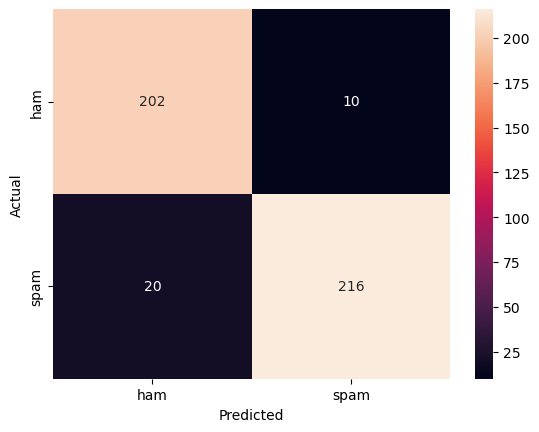

In [193]:
plt.style.use('default')
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=["ham", "spam"], yticklabels=["ham", "spam"])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.savefig(image_folder+'cm.png')
plt.show()

Loss:

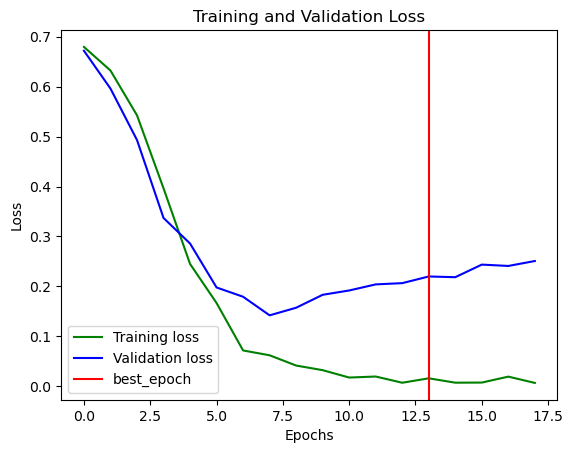

In [194]:
best_epoch = es.best_epoch + 1

#epochs = range(1, num_epochs+1)
plt.plot(history.history['loss'], 'g', label='Training loss')
plt.plot(history.history['val_loss'], 'b', label='Validation loss')
plt.axvline(x=best_epoch, color='r', label='best_epoch')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig(image_folder+'loss.png')
plt.show()

Accuracy: 

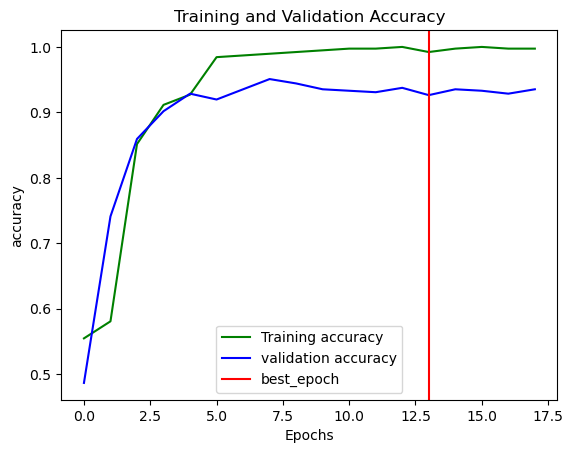

In [195]:
plt.plot( history.history['accuracy'], 'g', label='Training accuracy')
plt.plot(history.history['val_accuracy'], 'b', label='validation accuracy')
plt.axvline(x=best_epoch, color='r', label='best_epoch')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.legend()
plt.savefig(image_folder+'accuracy.png')
plt.show()

Precission:

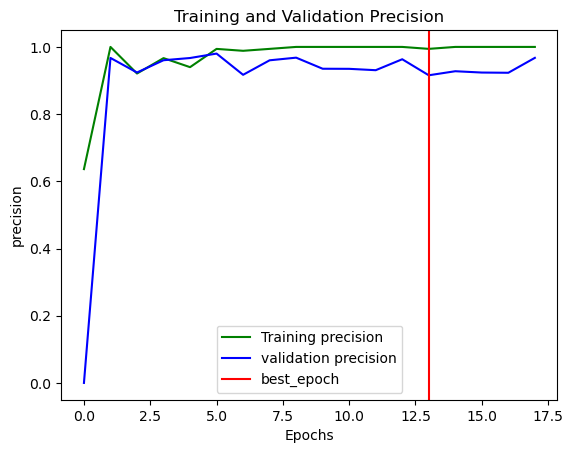

In [196]:
epochs = range(1, num_epochs+1)
plt.plot(history.history['precision'], 'g', label='Training precision')
plt.plot(history.history['val_precision'], 'b', label='validation precision')
plt.axvline(x=best_epoch, color='r', label='best_epoch')
plt.title('Training and Validation Precision')
plt.xlabel('Epochs')
plt.ylabel('precision')
plt.legend()
plt.savefig(image_folder+'precision.png')
plt.show()